In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# This converts the images (0-255) into Tensors (0.0 - 1.0)
transform = transforms.Compose([transforms.ToTensor()])

# Download and load training data
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Create a loader to feed data in batches of 32 images at a time
train_loader: DataLoader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader: DataLoader = DataLoader(test_data, batch_size=32, shuffle=True)

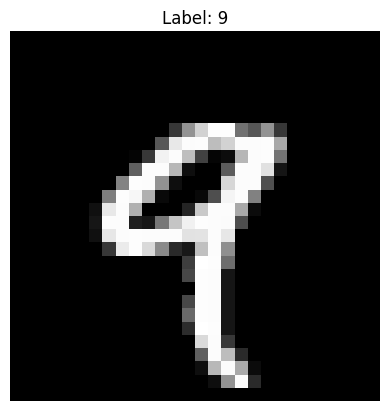

In [2]:
import matplotlib.pyplot as plt

# 1. Grab the raw image tensor
image = train_data.data[4]
label = train_data.targets[4]

# 2. Plot it
plt.imshow(image, cmap="gray") # cmap="gray" forces black & white
plt.title(f"Label: {label}")
plt.axis("off") # Optional: Hides the ruler numbers
plt.show()

In [3]:
import torch.nn as nn
import torch
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"

neuralNetwork = NeuralNetwork().to(device)
neuralNetwork
    

/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory
/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


NeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [4]:
import torch.optim as optim

# CrossEntropyLoss is standard for classification (choosing 1 out of N categories)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(neuralNetwork.parameters(), lr=0.001)

In [5]:
from sklearn.metrics import accuracy_score


# Add channel dimension (1) expected by Conv2d: (batch, 1, 28, 28)
X_train = (train_data.data[:1000].unsqueeze(1).float() / 255.0).to(device)
X_test = (test_data.data[:100].unsqueeze(1).float() / 255.0).to(device)
y_train = train_data.targets[:1000].long().to(device)
y_test = test_data.targets[:100].long().to(device)

epochs = 5000
for epoch in range(epochs):
    neuralNetwork.train()

    # Forward pass
    y_logits = neuralNetwork(X_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) 

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_score(y_true=y_train.cpu(), y_pred=y_pred.cpu())

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    neuralNetwork.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = neuralNetwork(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_score(y_true=y_test.cpu(), y_pred=test_pred.cpu())

    if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2%} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2%}")

Epoch: 0 | Loss: 2.30592, Acc: 8.60% | Test Loss: 2.31494, Test Acc: 8.00%
Epoch: 100 | Loss: 2.29616, Acc: 9.50% | Test Loss: 2.30468, Test Acc: 8.00%
Epoch: 200 | Loss: 2.28791, Acc: 10.90% | Test Loss: 2.29599, Test Acc: 8.00%
Epoch: 300 | Loss: 2.28021, Acc: 13.10% | Test Loss: 2.28796, Test Acc: 11.00%
Epoch: 400 | Loss: 2.27233, Acc: 18.30% | Test Loss: 2.27977, Test Acc: 16.00%
Epoch: 500 | Loss: 2.26380, Acc: 25.00% | Test Loss: 2.27095, Test Acc: 27.00%
Epoch: 600 | Loss: 2.25427, Acc: 33.50% | Test Loss: 2.26120, Test Acc: 32.00%
Epoch: 700 | Loss: 2.24347, Acc: 38.80% | Test Loss: 2.25020, Test Acc: 35.00%
Epoch: 800 | Loss: 2.23122, Acc: 42.70% | Test Loss: 2.23765, Test Acc: 39.00%
Epoch: 900 | Loss: 2.21728, Acc: 45.90% | Test Loss: 2.22351, Test Acc: 43.00%
Epoch: 1000 | Loss: 2.20123, Acc: 49.30% | Test Loss: 2.20737, Test Acc: 44.00%
Epoch: 1100 | Loss: 2.18259, Acc: 52.30% | Test Loss: 2.18865, Test Acc: 46.00%
Epoch: 1200 | Loss: 2.16067, Acc: 53.70% | Test Loss: 2.1

In [8]:
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    neuralNetwork.train()
    train_loss, train_acc = 0, 0
    # X is the images y is the labels
    for batch, (X, y) in enumerate(train_loader):
        # --- SANITY CHECK (Verifies data is correct) ---
        if epoch == 0 and batch == 0:
            print(f"DEBUG: Data Range is {X.min():.2f} to {X.max():.2f}")
            if X.max() > 1.0:
                print("!! WARNING: Data is not normalized (0-255). Check transforms !!")
        # -----------------------------------------------

        X, y = X.to(device), y.to(device)

        # Forward
        y_pred = neuralNetwork(X)
        
        # Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # Accuracy
        train_acc += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate averages
    train_loss /= len(train_loader)
    train_acc /= len(train_loader.dataset) #type: ignore
    
    print(f"Train Loss: {train_loss:.5f} | Train Acc: {train_acc:.2%}")

Epoch 1
-------------------------------
DEBUG: Data Range is 0.00 to 1.00
Train Loss: 2.24308 | Train Acc: 46.20%
Epoch 2
-------------------------------
Train Loss: 1.63861 | Train Acc: 70.23%
Epoch 3
-------------------------------
Train Loss: 0.59559 | Train Acc: 84.28%
Epoch 4
-------------------------------
Train Loss: 0.40326 | Train Acc: 88.45%
Epoch 5
-------------------------------
Train Loss: 0.34235 | Train Acc: 89.97%
Epoch 6
-------------------------------
Train Loss: 0.30800 | Train Acc: 90.96%
Epoch 7
-------------------------------
Train Loss: 0.28258 | Train Acc: 91.60%
Epoch 8
-------------------------------
Train Loss: 0.26038 | Train Acc: 92.26%
Epoch 9
-------------------------------
Train Loss: 0.24085 | Train Acc: 92.85%
Epoch 10
-------------------------------
Train Loss: 0.22279 | Train Acc: 93.36%


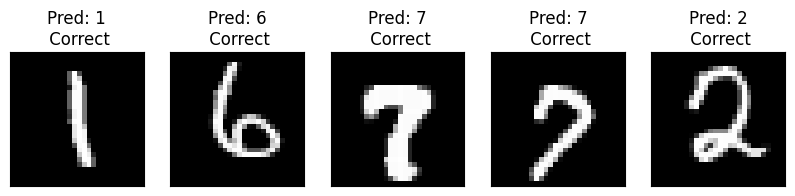

In [11]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(iter(train_loader))

# Get predictions
with torch.no_grad(): # Tell PyTorch we don't need gradients for this (saves memory)
    images = images.to(device)  # Move images to the same device as the model
    outputs = neuralNetwork(images)
    # The prediction is the index with the highest score
    _, predicted = torch.max(outputs, 1)

# Show the first 5 images and their predictions
fig = plt.figure(figsize=(10, 2))
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    # Convert tensor image back to numpy for display
    # .cpu() moves it back to system memory
    img = images[i].cpu().squeeze().numpy()
    ax.imshow(img, cmap='gray')
    is_correct = predicted[i].item() == labels[i].item()
    ax.set_title(f"Pred: {predicted[i].item()}\n {'Correct' if is_correct else 'Incorrect'}")
plt.show()
